- описание данных: https://www.kaggle.com/competitions/playground-series-s4e1/discussion/465045


## Установка и загрузка библиотек

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split

import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle

np.random.seed(1635848)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Чтение данных

In [ ]:
#raw_data = loadarff('EEG Eye State.arff')
df = pd.read_csv('/content/gdrive/MyDrive/hse/anonymization/bank2_data.csv')

In [ ]:
df = df[df.columns[1:]]
df = df.drop(columns = 'Surname')

In [ ]:
df = df.rename(columns = {'CustomerId' : 'id', 'CreditScore' : 'credit_score',
                         'Geography' : 'country', 'Gender' : 'gender', 'Age' : 'age',
                          'Tenure' : 'loyalty_years', 'Balance' : 'balance',
                          'NumOfProducts' : 'product_num', 'HasCrCard' : 'has_cred_card',
                         'IsActiveMember' : 'is_bank_member', 'EstimatedSalary' : 'estimated_salary',
                         'Exited' : 'is_exited'})

In [ ]:
df.head()

,id,credit_score,country,gender,age,loyalty_years,balance,product_num,has_cred_card,is_bank_member,estimated_salary,is_exited
0,15674932,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [ ]:
#df.head().to_excel('df.xlsx', index = False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                165034 non-null  int64  
 1   credit_score      165034 non-null  int64  
 2   country           165034 non-null  object 
 3   gender            165034 non-null  object 
 4   age               165034 non-null  float64
 5   loyalty_years     165034 non-null  int64  
 6   balance           165034 non-null  float64
 7   product_num       165034 non-null  int64  
 8   has_cred_card     165034 non-null  float64
 9   is_bank_member    165034 non-null  float64
 10  estimated_salary  165034 non-null  float64
 11  is_exited         165034 non-null  int64  
dtypes: float64(5), int64(5), object(2)
memory usage: 15.1+ MB


In [ ]:
df.isna().sum()

,0
id,0
credit_score,0
country,0
gender,0
age,0
loyalty_years,0
balance,0
product_num,0
has_cred_card,0
is_bank_member,0


<Axes: >

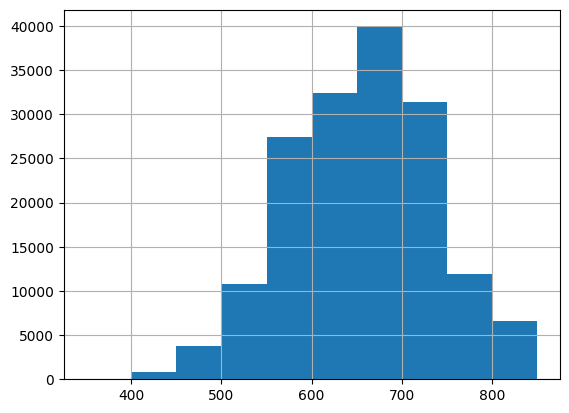

In [ ]:
df.credit_score.hist()

In [ ]:
df.country.value_counts()

,count
country,
France,94215
Spain,36213
Germany,34606


In [ ]:
df.gender.value_counts()

,count
gender,
Male,93150
Female,71884


<Axes: >

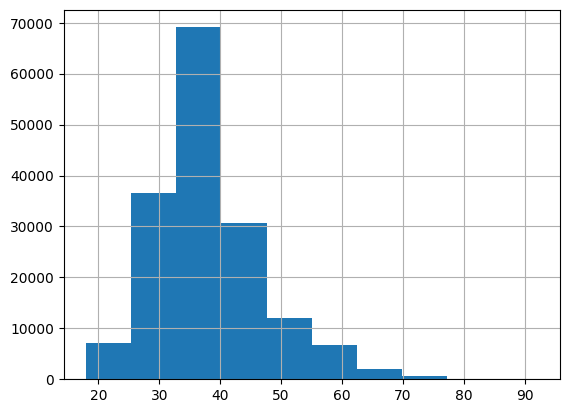

In [ ]:
df.age.hist()

In [ ]:
df.loyalty_years.value_counts(normalize = True) * 100

,proportion
loyalty_years,
2,10.934111
7,10.791716
4,10.636596
8,10.615994
5,10.463298
1,10.155483
9,10.124580
3,10.076711
6,9.587115


<Axes: >

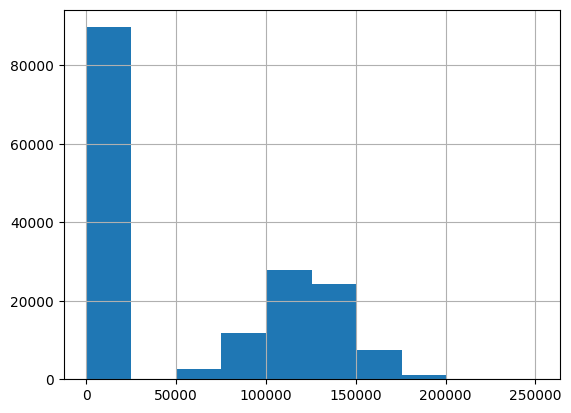

In [ ]:
df.balance.hist()

In [ ]:
df.product_num.value_counts(normalize = True) * 100

,proportion
product_num,
2,51.074930
1,46.883672
3,1.753578
4,0.287819


In [ ]:
df.has_cred_card.value_counts(normalize = True) * 100

,proportion
has_cred_card,
1.0,75.395373
0.0,24.604627


In [ ]:
df.is_bank_member.value_counts(normalize = True) * 100

,proportion
is_bank_member,
0.0,50.222984
1.0,49.777016


<Axes: >

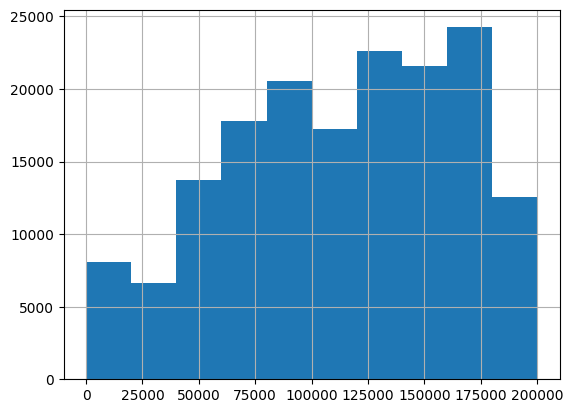

In [ ]:
df.estimated_salary.hist()

In [ ]:
df.is_exited.value_counts(normalize = True) * 100

,proportion
is_exited,
0,78.840118
1,21.159882


In [ ]:
df = pd.get_dummies(df, columns = ['country', 'gender'], dtype = 'int64', drop_first = True)

In [ ]:
df = df.drop(columns = 'id')

In [ ]:
df.age = df.age.astype('int64')
df.has_cred_card = df.has_cred_card.astype('int64')
df.is_bank_member = df.is_bank_member.astype('int64')

In [ ]:
df.head()

,credit_score,age,loyalty_years,balance,product_num,has_cred_card,is_bank_member,estimated_salary,is_exited,country_Germany,country_Spain,gender_Male
0,668,33,3,0.00,2,1,0,181449.97,0,0,0,1
1,627,33,1,0.00,2,1,1,49503.50,0,0,0,1
2,678,40,10,0.00,2,1,0,184866.69,0,0,0,1
3,581,34,2,148882.54,1,1,1,84560.88,0,0,0,1
4,716,33,5,0.00,2,1,1,15068.83,0,0,1,1


In [ ]:
from matplotlib import pyplot
import seaborn as sns

In [ ]:
#scaler = StandardScaler()

In [ ]:
X = df.drop(columns = 'is_exited')
y = df['is_exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split

In [ ]:
lgb_1 = lgb.LGBMClassifier()
lgb_1.fit(X_train, y_train)

#y_pred = lgb_1.predict(X_test)

# evaluation
#print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 27929, number of negative: 104098
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211540 -> initscore=-1.315667
[LightGBM] [Info] Start training from score -1.315667


LGBMClassifier()

In [ ]:
preds = lgb_1.predict(X_test)
proba = lgb_1.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, preds)
print(accuracy)
f1 = f1_score(y_test, preds)
print(f1)
precision = precision_score(y_test, preds)
print(precision)
recall = recall_score(y_test, preds)
print(recall)
auc = roc_auc_score(y_test, proba)
print(auc)

0.8677250280243585
0.6453866146848602
0.7468045112781955
0.568220823798627
0.8926289829710108


In [ ]:
!pip install sdv

In [ ]:
X_train.columns

Index(['credit_score', 'age', 'loyalty_years', 'balance', 'product_num',
       'has_cred_card', 'is_bank_member', 'estimated_salary',
       'country_Germany', 'country_Spain', 'gender_Male'],
      dtype='object')

In [ ]:
X_train_cut = X_train
y_train_cut = y_train

In [ ]:
X_train_cut.shape

(132027, 11)

In [ ]:
syn_data = pd.concat([X_train_cut, y_train_cut], axis = 1)

In [ ]:
from sdv.metadata import Metadata
from sdv.single_table import CTGANSynthesizer

metadata = Metadata.detect_from_dataframe(data=syn_data)

In [ ]:
synthesizer = CTGANSynthesizer(
    metadata, # required
    enforce_rounding=False,
    epochs=200,
    verbose=True
)

/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [ ]:
synthesizer.fit(syn_data)

Gen. (-2.33) | Discrim. (-0.03): 100%|██████████| 200/200 [1:20:13<00:00, 24.07s/it]


In [ ]:
synthesizer.save('synthesizer_1503_all.pkl')

In [ ]:
import pickle


with open('synthesizer_1503_all.pkl', 'rb') as f:
    synthesizer = pickle.load(f)

In [ ]:
fig = synthesizer.get_loss_values_plot()
fig.show()

In [ ]:
synthesizer.get_parameters()

{'enforce_min_max_values': True,
 'enforce_rounding': False,
 'locales': ['en_US'],
 'embedding_dim': 128,
 'generator_dim': (256, 256),
 'discriminator_dim': (256, 256),
 'generator_lr': 0.0002,
 'generator_decay': 1e-06,
 'discriminator_lr': 0.0002,
 'discriminator_decay': 1e-06,
 'batch_size': 500,
 'discriminator_steps': 1,
 'log_frequency': True,
 'verbose': True,
 'epochs': 200,
 'pac': 10,
 'cuda': True}

In [ ]:
synthetic_data = synthesizer.sample(num_rows=syn_data.shape[0])

In [ ]:
synthetic_data.head()

,credit_score,age,loyalty_years,balance,product_num,has_cred_card,is_bank_member,estimated_salary,country_Germany,country_Spain,gender_Male,is_exited
0,638,32,5,141301.232929,2,1,0,154474.130191,0,1,0,0
1,660,37,4,0.000000,2,0,1,152624.202288,0,0,1,0
2,660,38,10,370.605929,1,1,1,95524.632525,0,0,0,1
3,643,38,3,81262.265623,2,1,1,36365.348976,0,1,0,0
4,638,32,7,134742.755633,2,1,1,182086.502283,1,1,0,0


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split

In [ ]:
#синтетические данные
X_train_gen, X_test_gen, y_train_gen, y_test_gen = train_test_split(synthetic_data.drop(columns = 'is_exited'),
                                                                    synthetic_data[['is_exited']], random_state = 44)

In [ ]:
#реальные данные
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X_train_cut, y_train_cut, random_state = 44)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

cls = DecisionTreeClassifier()
cls.fit(X_train_real, y_train_real)

preds = cls.predict(X_test_real)
proba = cls.predict_proba(X_test_real)[:, 1]

accuracy = accuracy_score(y_test_real, preds)
print(accuracy)
f1 = f1_score(y_test_real, preds)
print(f1)
precision = precision_score(y_test_real, preds)
print(precision)
recall = recall_score(y_test_real, preds)
print(recall)
auc = roc_auc_score(y_test_real, proba)
print(auc)

0.795073772230133
0.5237290522461625
0.5160260857499653
0.5316654753395282
0.6992020178293474


In [ ]:
#классификатор для обучения на синтетических данных
cls_synth = DecisionTreeClassifier()
cls_synth.fit(X_train_gen, y_train_gen)

preds_gen = cls_synth.predict(X_test_gen)
proba_gen = cls_synth.predict_proba(X_test_gen)[:, 1]

accuracy_gen = accuracy_score(y_test_gen, preds_gen)
print(accuracy_gen)
f1_gen = f1_score(y_test_gen, preds_gen)
print(f1_gen)
precision_gen = precision_score(y_test_gen, preds_gen)
print(precision_gen)
recall_gen = recall_score(y_test_gen, preds_gen)
print(recall_gen)
auc_gen = roc_auc_score(y_test_gen, proba_gen)
print(auc_gen)

0.7224225164359075
0.532073544433095
0.5234649783941312
0.5409699864991172
0.6690648546577201


In [ ]:
metrics = {'data': ['real', 'synthetic'], 'accuracy': [], 'precision': [], 'recall': [], 'F1 score': [], 'RocAuc': []}

In [ ]:
metrics['recall'].append(recall)
metrics['recall'].append(recall_gen)

metrics['precision'].append(precision)
metrics['precision'].append(precision_gen)

metrics['RocAuc'].append(auc)
metrics['RocAuc'].append(auc_gen)

metrics['F1 score'].append(f1)
metrics['F1 score'].append(f1_gen)

metrics['accuracy'].append(accuracy)
metrics['accuracy'].append(accuracy_gen)

In [ ]:
# new
pd.DataFrame(metrics)

,data,accuracy,precision,recall,F1 score,RocAuc
0,real,0.795074,0.516026,0.531665,0.523729,0.699202
1,synthetic,0.722423,0.523465,0.540970,0.532074,0.669065


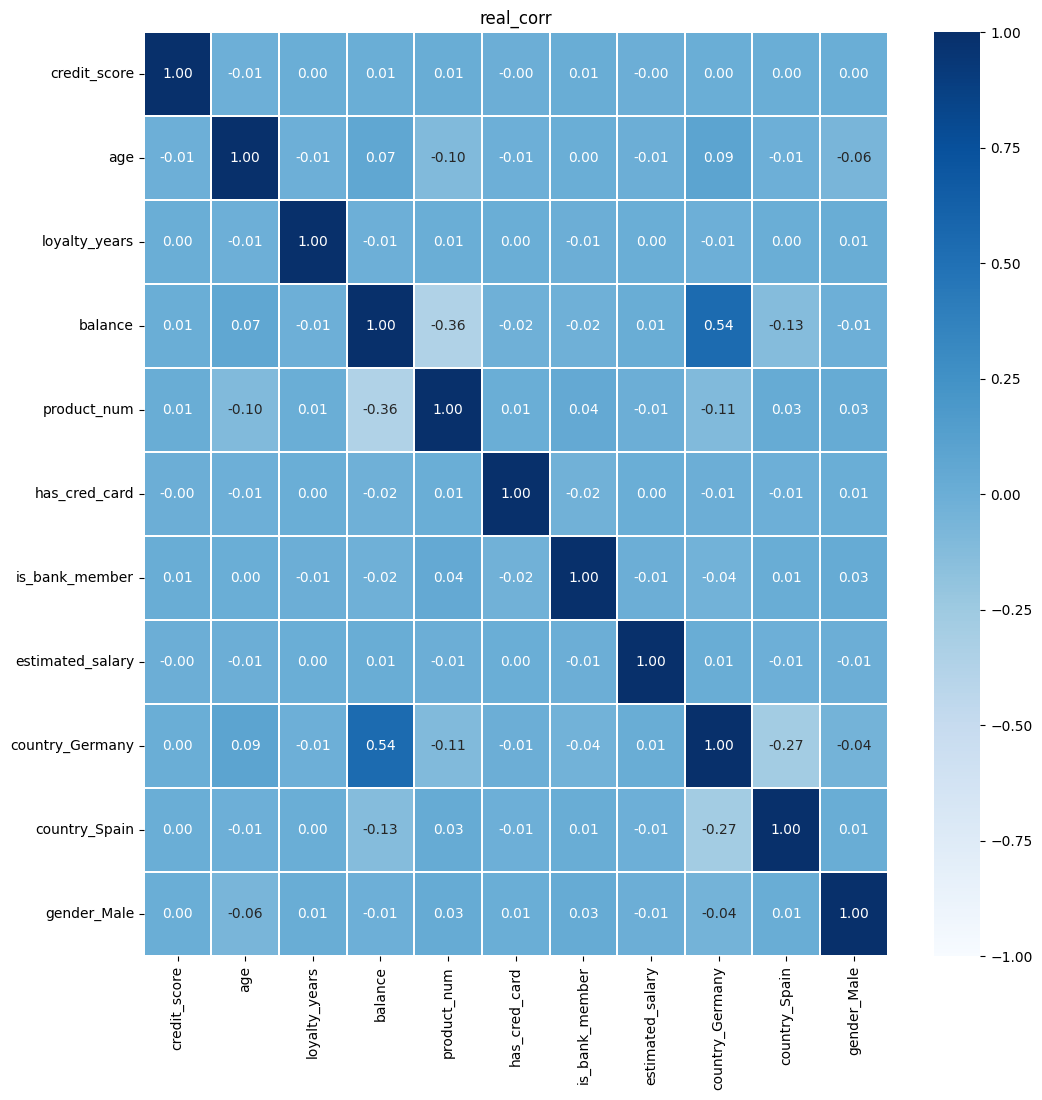

In [ ]:
sns.heatmap(X_train_cut.corr(), annot=True, cmap="Blues", linewidths=0.2, vmin=-1, vmax=1, fmt=".2f")
fig = plt.gcf()
fig.set_size_inches(12, 12)
plt.title('real_corr')
plt.show()

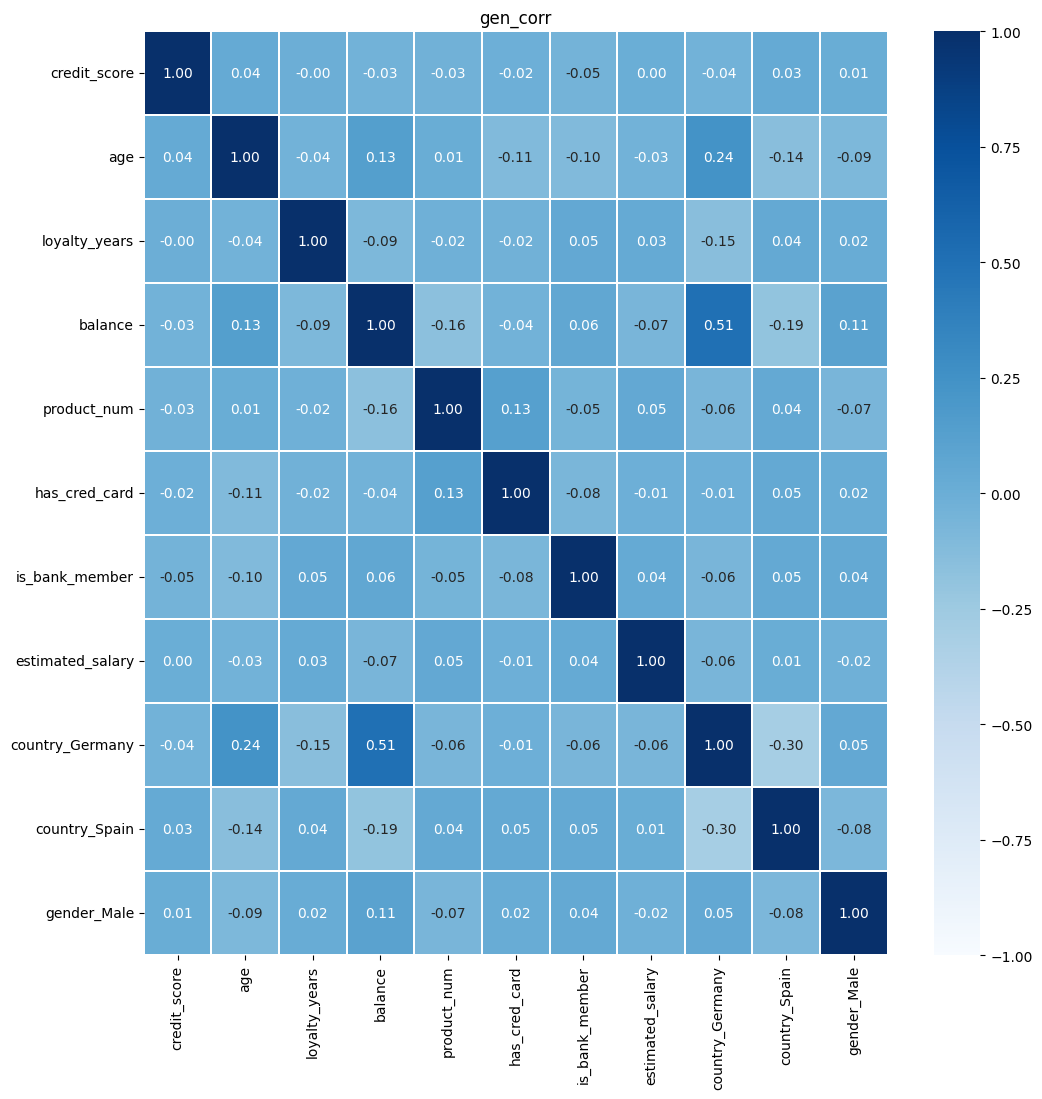

In [ ]:
sns.heatmap(X_train_gen.corr(), annot=True, cmap="Blues", linewidths=0.2, vmin=-1, vmax=1, fmt=".2f")
fig = plt.gcf()
fig.set_size_inches(12, 12)
plt.title('gen_corr')
plt.show()

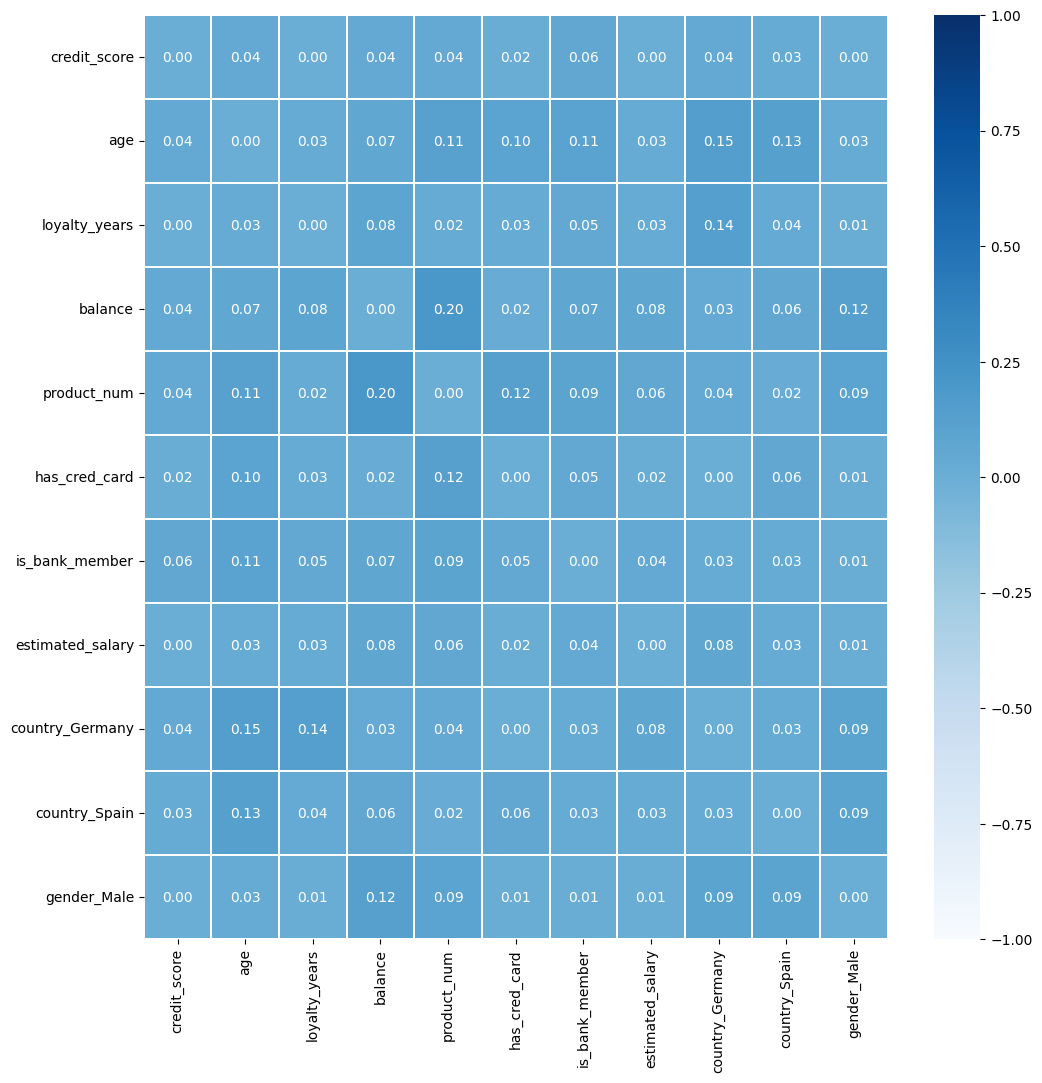

In [ ]:
sns.heatmap(abs(X_train_cut.corr() - X_train_gen.corr()), annot=True, cmap="Blues", linewidths=0.2, vmin=-1, vmax=1, fmt=".2f")
fig = plt.gcf()
fig.set_size_inches(12, 12)
plt.show()

In [ ]:
discrete_columns = ['loyalty_years', 'product_num', 'has_cred_card',
                    'is_bank_member', 'country_Germany', 'country_Spain',
                    'gender_Male']
cont_columns = ['credit_score', 'age', 'balance', 'estimated_salary']

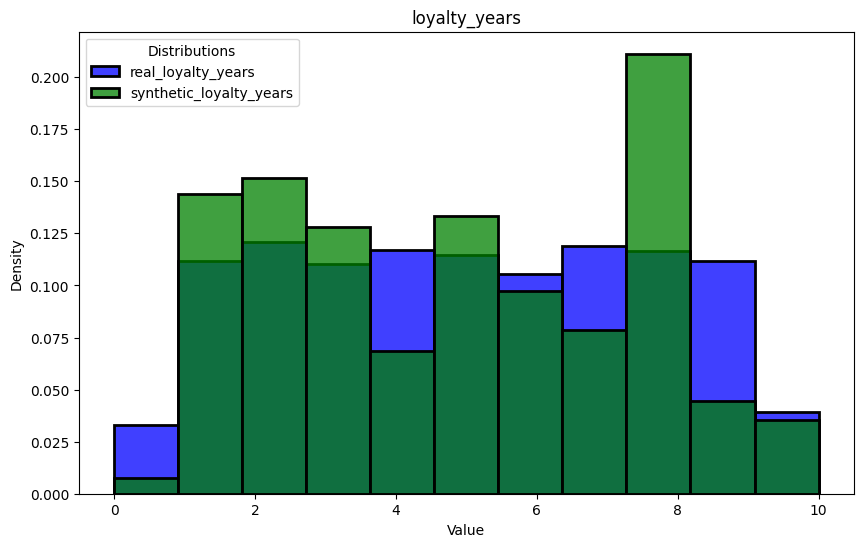

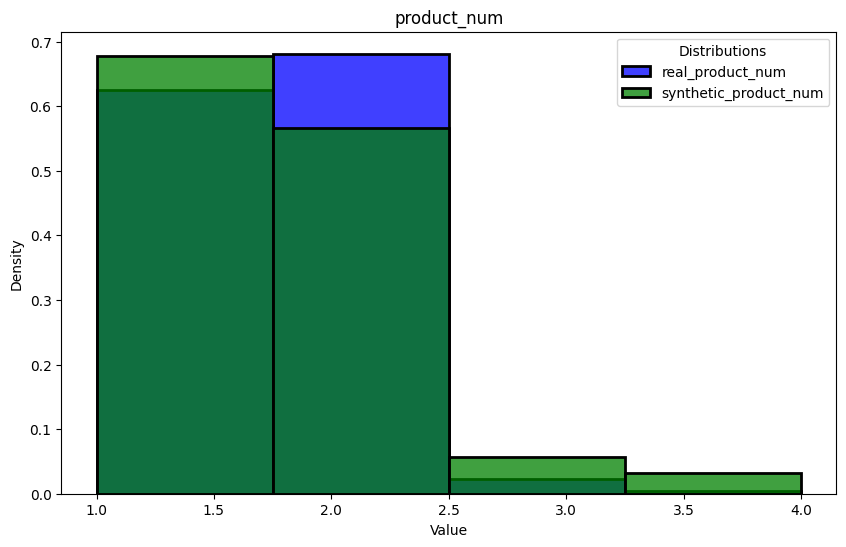

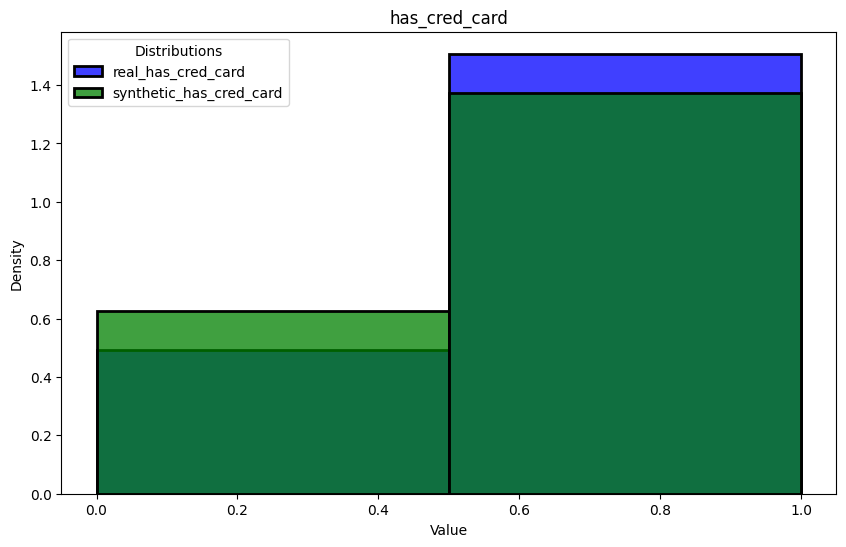

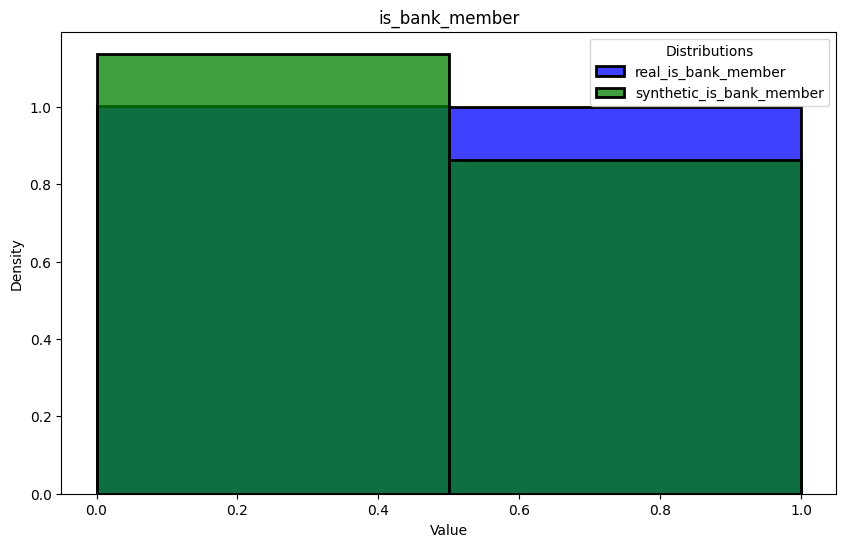

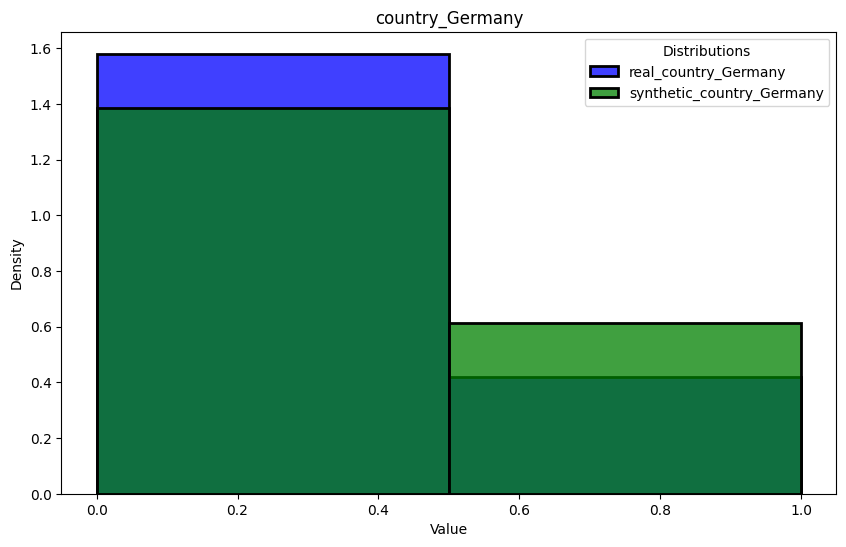

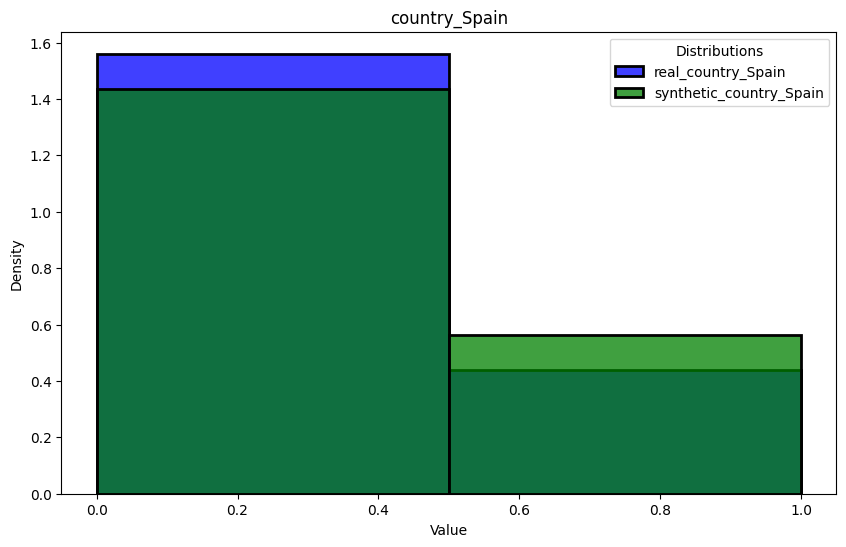

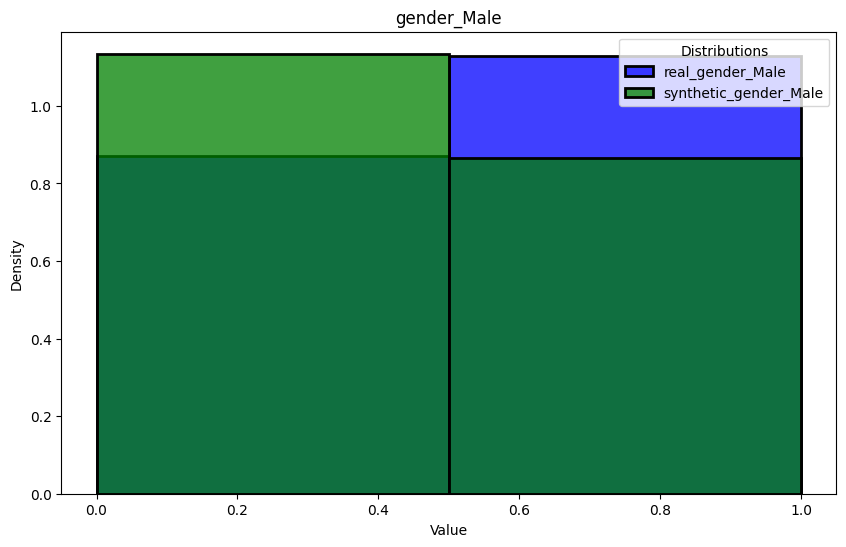

In [ ]:
for feature in discrete_columns:
    plt.figure(figsize=(10, 6))

    # Строим распределение для признака из df1 и df2
    sns.histplot(X_train_cut[feature], color='blue', label=f'real_{feature}', stat='density',
                 linewidth=2, bins = X_train_cut[feature].nunique())
    sns.histplot(synthetic_data[feature], color='green', label=f'synthetic_{feature}', stat='density',
                 linewidth=2, bins = synthetic_data[feature].nunique())

    # Добавляем легенду, подписи осей и заголовок
    plt.legend(title='Distributions')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(feature)

    # Отображаем график
    plt.show()

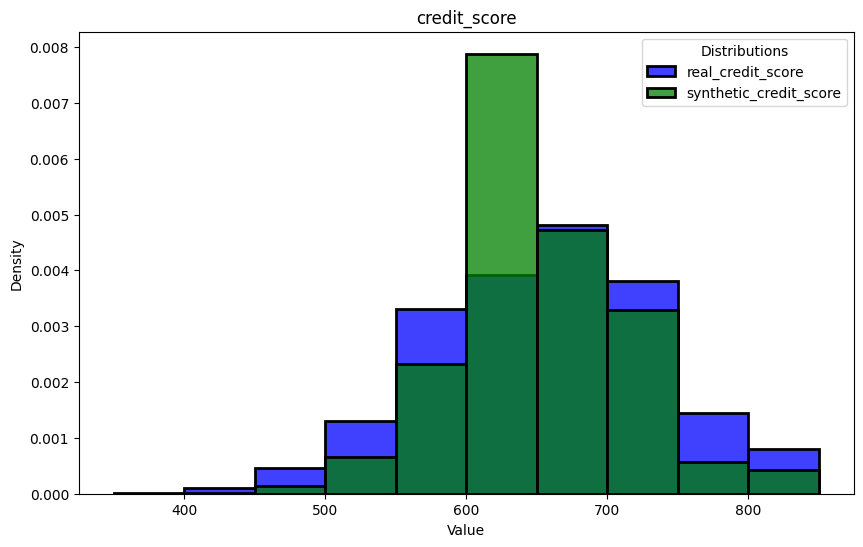

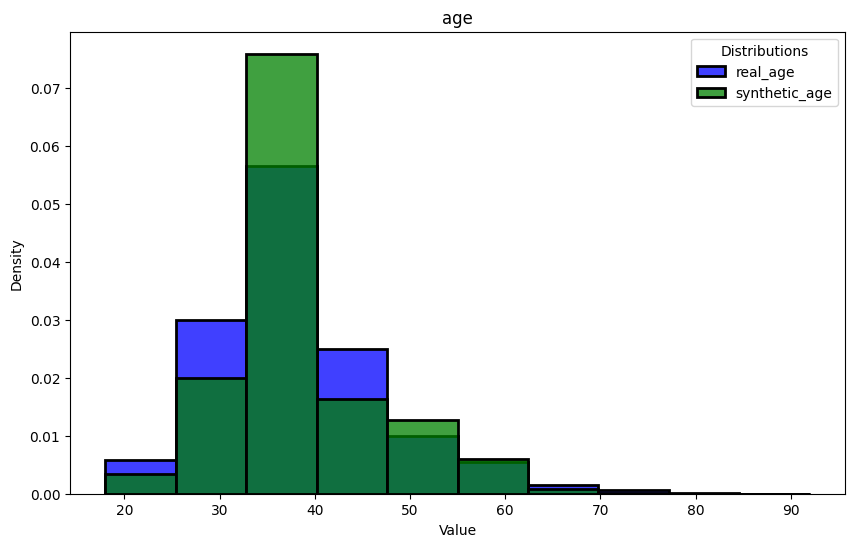

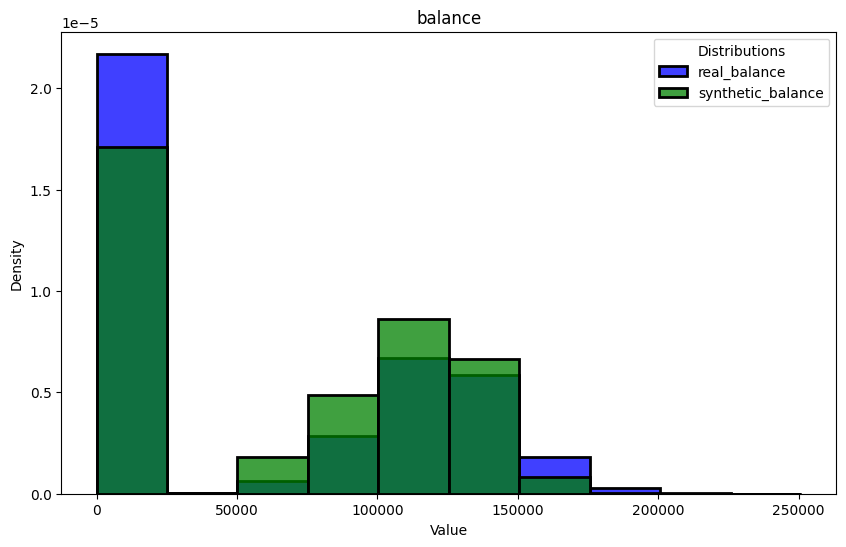

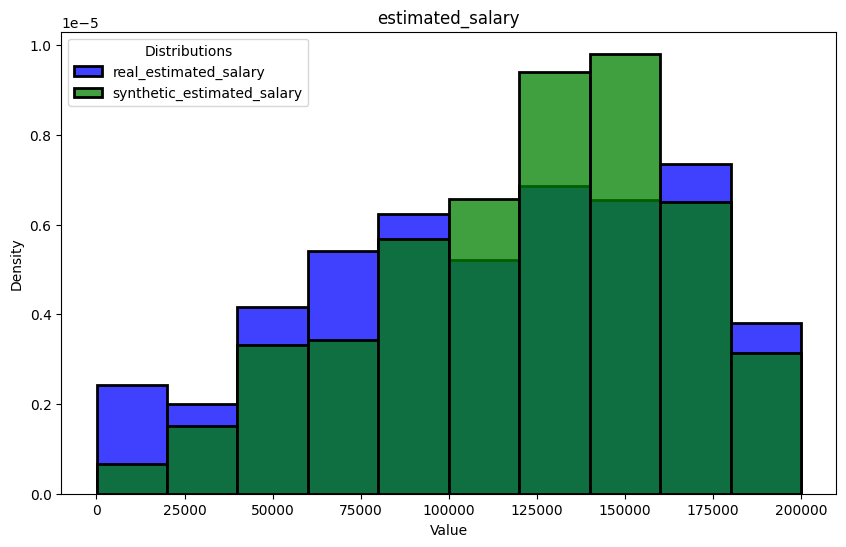

In [ ]:
for feature in cont_columns:
    plt.figure(figsize=(10, 6))

    # Строим распределение для признака из df1 и df2
    sns.histplot(X_train_cut[feature], color='blue', label=f'real_{feature}', stat='density',
                 linewidth=2, binrange = (X_train_cut[feature].min(), X_train_cut[feature].max()),
             binwidth = (X_train_cut[feature].max() - X_train_cut[feature].min()) / 10)
    sns.histplot(synthetic_data[feature], color='green', label=f'synthetic_{feature}', stat='density',
                linewidth=2, binrange = (X_train_cut[feature].min(), X_train_cut[feature].max()),
             binwidth = (X_train_cut[feature].max() - X_train_cut[feature].min()) / 10)

    # Добавляем легенду, подписи осей и заголовок
    plt.legend(title='Distributions')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(feature)

    # Отображаем график
    plt.show()

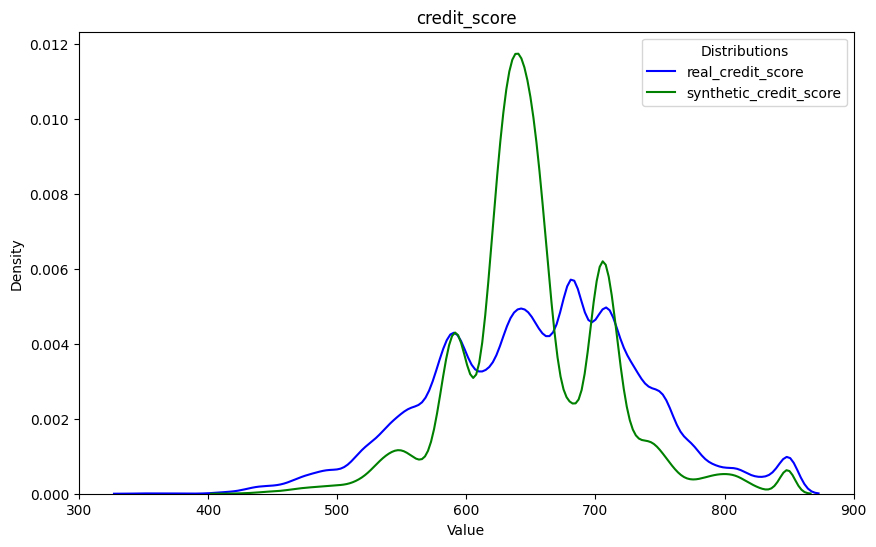

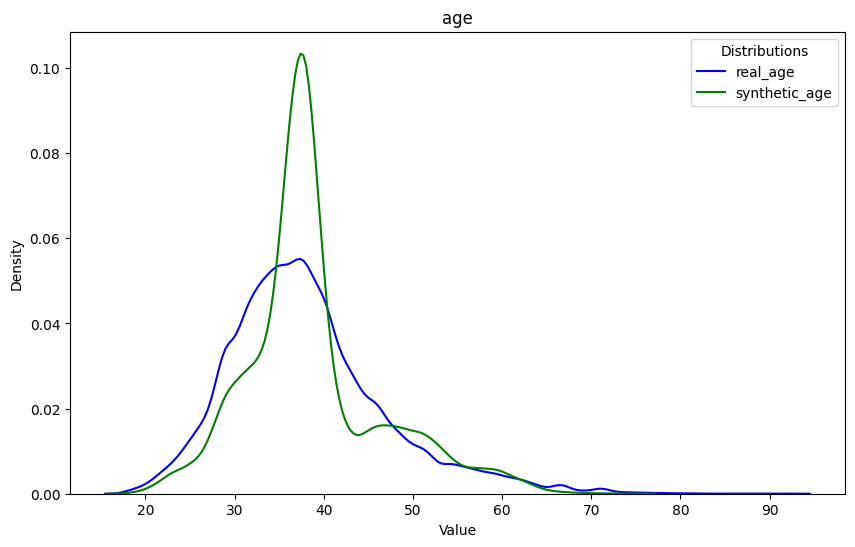

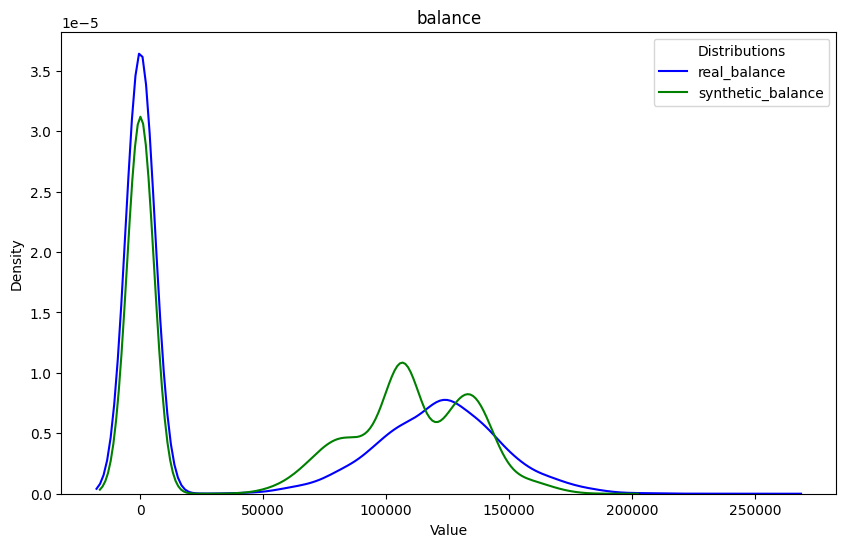

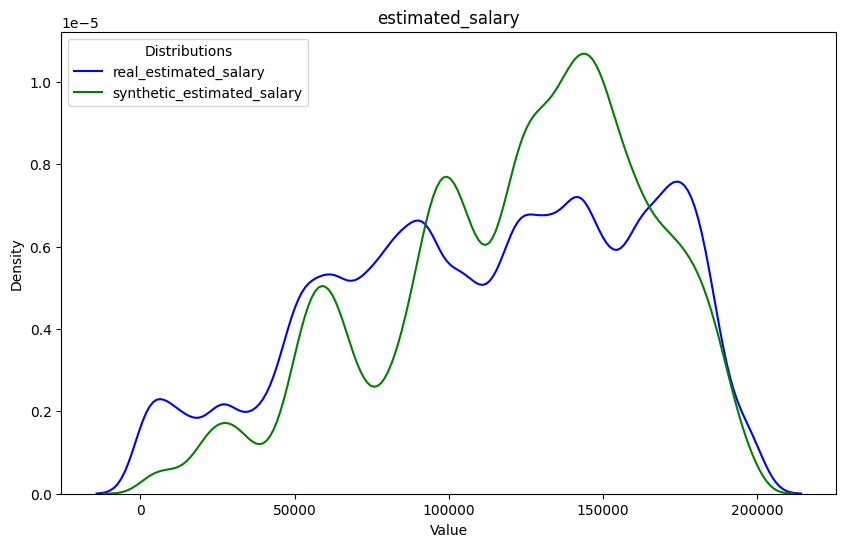

In [ ]:
for feature in cont_columns:
    plt.figure(figsize=(10, 6))

    # Строим распределение для признака из df1 и df2
    sns.kdeplot(X_train_cut[feature], color='blue', label=f'real_{feature}')
    sns.kdeplot(synthetic_data[feature], color='green', label=f'synthetic_{feature}')

    # Добавляем легенду, подписи осей и заголовок
    plt.legend(title='Distributions')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(feature)

    # Отображаем график
    plt.show()